<a href="https://colab.research.google.com/github/ShyamKrishna122/FODS_CASE_STUDY/blob/main/fods_case_study_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FODS CASE STUDY PART-2

## Imports

In [ ]:
#imports

import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_val_predict
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.feature_selection import VarianceThreshold
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import scipy.stats as st

## Loading Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ShyamKrishna122/FODS_CASE_STUDY/main/trips.csv')
df.head()

,cab_type,destination,source,id,product_id,name,distance,time_stamp,price,surge_multiplier
0,Uber,West End,North End,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1.11,1543615981179,12.0,1.0
1,Uber,West End,North End,23f145da-f0c1-4d1f-a184-496bc003a7db,6c84fd89-3f11-4782-9b50-97c468b19529,Black,1.11,1544698211014,16.0,1.0
2,Uber,West End,North End,357559cb-8c58-4278-a41a-e33b2e0997a3,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,1.11,1544728503935,7.5,1.0
3,Uber,West End,North End,50ef1165-9d23-416c-a65c-18906207b295,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,1.11,1545004511430,7.5,1.0
4,Uber,West End,North End,91c4861c-1780-42b0-bca1-bbd64a422cc3,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,1.11,1544748007961,26.0,1.0


## 1) Feature Engineering

### 1.1) Adding meaningful columns


*   We noticed that the time_stamp attribute is not in a proper format so we converted it into a proper format.
*   We also introduced a new attribute called fare_per_mile.This value was obtained by dividing the cab price and distance covered per ride.

In [ ]:
#convert 13digit time stamp to datetime format
df['date_time']= pd.to_datetime(df['time_stamp']/1000, unit='s')
df['date']= df['date_time'].dt.date
df['day'] = df.date_time.dt.dayofweek
df['hour'] = df.date_time.dt.hour
#extract hours only

In [ ]:
#After conversion to a new column time we can delete the exisitng column
del df['time_stamp']

In [ ]:
df['fare_per_mile'] = round(df.price/df.distance,2)
df

,cab_type,destination,source,id,product_id,name,distance,price,surge_multiplier,date_time,date,day,hour,fare_per_mile
0,Uber,West End,North End,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1.11,12.0,1.0,2018-11-30 22:13:01.178999901,2018-11-30,4,22,10.81
1,Uber,West End,North End,23f145da-f0c1-4d1f-a184-496bc003a7db,6c84fd89-3f11-4782-9b50-97c468b19529,Black,1.11,16.0,1.0,2018-12-13 10:50:11.013999939,2018-12-13,3,10,14.41
2,Uber,West End,North End,357559cb-8c58-4278-a41a-e33b2e0997a3,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,1.11,7.5,1.0,2018-12-13 19:15:03.934999943,2018-12-13,3,19,6.76
3,Uber,West End,North End,50ef1165-9d23-416c-a65c-18906207b295,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,1.11,7.5,1.0,2018-12-16 23:55:11.430000067,2018-12-16,6,23,6.76
4,Uber,West End,North End,91c4861c-1780-42b0-bca1-bbd64a422cc3,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,1.11,26.0,1.0,2018-12-14 00:40:07.960999966,2018-12-14,4,0,23.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,Uber,North End,Theatre District,9965d180-6adb-4522-bc93-224a711da91a,6c84fd89-3f11-4782-9b50-97c468b19529,Black,1.57,16.0,1.0,2018-12-17 08:20:04.813999891,2018-12-17,0,8,10.19
15986,Uber,North End,Theatre District,9a0fd4f5-aac1-4c69-b7f9-b4162678c53f,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,1.57,7.0,1.0,2018-12-02 22:17:59.582000017,2018-12-02,6,22,4.46
15987,Uber,North End,Theatre District,a906f8df-c9c6-427b-aa04-86eba591106b,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1.57,NaN,1.0,2018-11-28 11:17:07.775000095,2018-11-28,2,11,NaN
15988,Uber,Haymarket Square,Theatre District,0a5bab4d-14ed-4bea-9095-f3a7b94e6a37,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,1.61,9.5,1.0,2018-12-01 14:23:04.382999897,2018-12-01,5,14,5.90


Dropping certain columns as they are not neccessary for predictions

In [ ]:
df = df.drop(['cab_type','id','product_id'], axis=1)

In [ ]:
df.dtypes

destination                 object
source                      object
name                        object
distance                   float64
price                      float64
surge_multiplier           float64
date_time           datetime64[ns]
date                        object
day                          int64
hour                         int64
fare_per_mile              float64
dtype: object

### 1.2)Handling null values

In [ ]:
df.isnull().sum()

destination            0
source                 0
name                   0
distance               0
price               2292
surge_multiplier       0
date_time              0
date                   0
day                    0
hour                   0
fare_per_mile       2292
dtype: int64

As we can see null values are present in the column "price".So we will be dropping all the rows with price having null value.

In [ ]:
#Dropping rows with price with null values.
df.dropna(subset=['price'], inplace=True)

df.isnull().sum()

destination         0
source              0
name                0
distance            0
price               0
surge_multiplier    0
date_time           0
date                0
day                 0
hour                0
fare_per_mile       0
dtype: int64

### 1.3)Handling Outiers(using IQR)

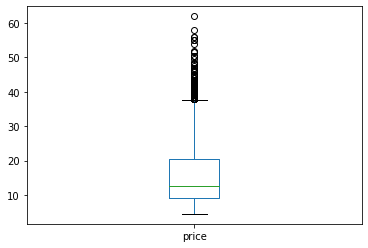

In [ ]:
df.boxplot( column =['price'], grid = False)

Here we will be removing all the rows with price column exxceeding the upper bound or is less than the lower bound. 

In [ ]:
Q1 = np.percentile(df['price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

l_b  = np.where(df['price'] <= (Q1-1.5*IQR))

print("Inter Quartile Range: ",IQR)
print("Upper Bound: ",Q3+1.5*IQR)
print("Lower Bound: ",Q1-1.5*IQR)

df = df.loc[df['price'] <= (Q3+1.5*IQR)].loc[df['price'] >= (Q1-1.5*IQR)]

df


Inter Quartile Range:  11.5
Upper Bound:  37.75
Lower Bound:  -8.25


,destination,source,name,distance,price,surge_multiplier,date_time,date,day,hour,fare_per_mile
0,West End,North End,UberXL,1.11,12.0,1.0,2018-11-30 22:13:01.178999901,2018-11-30,4,22,10.81
1,West End,North End,Black,1.11,16.0,1.0,2018-12-13 10:50:11.013999939,2018-12-13,3,10,14.41
2,West End,North End,UberX,1.11,7.5,1.0,2018-12-13 19:15:03.934999943,2018-12-13,3,19,6.76
3,West End,North End,WAV,1.11,7.5,1.0,2018-12-16 23:55:11.430000067,2018-12-16,6,23,6.76
4,West End,North End,Black SUV,1.11,26.0,1.0,2018-12-14 00:40:07.960999966,2018-12-14,4,0,23.42
...,...,...,...,...,...,...,...,...,...,...,...
15984,North End,Theatre District,UberPool,1.57,7.5,1.0,2018-12-16 22:50:09.970999956,2018-12-16,6,22,4.78
15985,North End,Theatre District,Black,1.57,16.0,1.0,2018-12-17 08:20:04.813999891,2018-12-17,0,8,10.19
15986,North End,Theatre District,UberX,1.57,7.0,1.0,2018-12-02 22:17:59.582000017,2018-12-02,6,22,4.46
15988,Haymarket Square,Theatre District,UberX,1.61,9.5,1.0,2018-12-01 14:23:04.382999897,2018-12-01,5,14,5.90


## 2) Feature Selection

### 2.1) Checking for columns with constant values

In [ ]:
def drop_constant_columns(dataset):
  var_thres=VarianceThreshold(threshold=0)
  var_thres.fit(dataset)
  var_thres.get_support()
  constant_columns=[column for column in dataset.columns if column not in dataset.columns[var_thres.get_support()]]

  return constant_columns


We can see that there is one feature which has constant value so we will remove it from our dataset.

In [ ]:
numerical_df = df.loc[:,df.dtypes!='object']
numerical_df1 = numerical_df.loc[:,numerical_df.dtypes!='datetime64[ns]']
constant_columns = drop_constant_columns(numerical_df1)
constant_columns

['surge_multiplier']

In [ ]:
df.drop(constant_columns,axis = 1,inplace=True)

In [ ]:
df

,destination,source,name,distance,price,date_time,date,day,hour,fare_per_mile
0,West End,North End,UberXL,1.11,12.0,2018-11-30 22:13:01.178999901,2018-11-30,4,22,10.81
1,West End,North End,Black,1.11,16.0,2018-12-13 10:50:11.013999939,2018-12-13,3,10,14.41
2,West End,North End,UberX,1.11,7.5,2018-12-13 19:15:03.934999943,2018-12-13,3,19,6.76
3,West End,North End,WAV,1.11,7.5,2018-12-16 23:55:11.430000067,2018-12-16,6,23,6.76
4,West End,North End,Black SUV,1.11,26.0,2018-12-14 00:40:07.960999966,2018-12-14,4,0,23.42
...,...,...,...,...,...,...,...,...,...,...
15984,North End,Theatre District,UberPool,1.57,7.5,2018-12-16 22:50:09.970999956,2018-12-16,6,22,4.78
15985,North End,Theatre District,Black,1.57,16.0,2018-12-17 08:20:04.813999891,2018-12-17,0,8,10.19
15986,North End,Theatre District,UberX,1.57,7.0,2018-12-02 22:17:59.582000017,2018-12-02,6,22,4.46
15988,Haymarket Square,Theatre District,UberX,1.61,9.5,2018-12-01 14:23:04.382999897,2018-12-01,5,14,5.90


### 2.2)Correlation Matrix Heatmap

*   Correlation shows how the features are related to each other or the target feature.
*   Correlation can be positive (an increase in one value of the feature increases the value of the target variable) or negative (an increase in one value of the feature decreases the value of the target variable).
*  If we find out that there are some features in your dataset that are correlated to each other, it means that they convey the same information. It is recommended to remove one of them.





In [ ]:
df.loc[:, df.columns != 'price'].corr()

,distance,day,hour,fare_per_mile
distance,1.000000,-0.015437,0.004119,-0.245187
day,-0.015437,1.000000,-0.013248,-0.004483
hour,0.004119,-0.013248,1.000000,0.009862
fare_per_mile,-0.245187,-0.004483,0.009862,1.000000


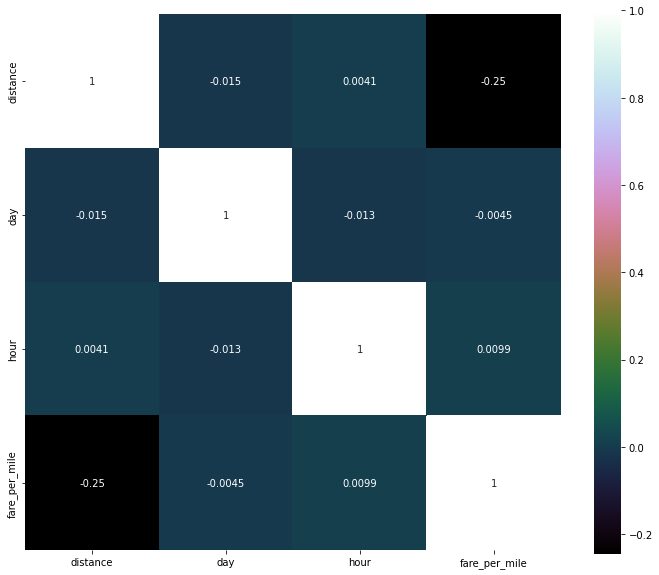

In [ ]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.loc[:, df.columns != 'price'].corr()
sns.heatmap(cor,vmax=1,square=True, annot=True,cmap='cubehelix')
plt.show()


**Removing highly correlated features**

In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with any other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

We can see that there is no features which are highly correlated with each other.So, there is no need to remove any numerical feature from our dataset.

In [ ]:
corr_features = correlation(df.loc[:, df.columns != 'price'], 0.7)
len(set(corr_features))

0

In [ ]:
corr_features

set()

In [ ]:
df

,destination,source,name,distance,price,date_time,date,day,hour,fare_per_mile
0,West End,North End,UberXL,1.11,12.0,2018-11-30 22:13:01.178999901,2018-11-30,4,22,10.81
1,West End,North End,Black,1.11,16.0,2018-12-13 10:50:11.013999939,2018-12-13,3,10,14.41
2,West End,North End,UberX,1.11,7.5,2018-12-13 19:15:03.934999943,2018-12-13,3,19,6.76
3,West End,North End,WAV,1.11,7.5,2018-12-16 23:55:11.430000067,2018-12-16,6,23,6.76
4,West End,North End,Black SUV,1.11,26.0,2018-12-14 00:40:07.960999966,2018-12-14,4,0,23.42
...,...,...,...,...,...,...,...,...,...,...
15984,North End,Theatre District,UberPool,1.57,7.5,2018-12-16 22:50:09.970999956,2018-12-16,6,22,4.78
15985,North End,Theatre District,Black,1.57,16.0,2018-12-17 08:20:04.813999891,2018-12-17,0,8,10.19
15986,North End,Theatre District,UberX,1.57,7.0,2018-12-02 22:17:59.582000017,2018-12-02,6,22,4.46
15988,Haymarket Square,Theatre District,UberX,1.61,9.5,2018-12-01 14:23:04.382999897,2018-12-01,5,14,5.90


### 2.3)Mutual Information

In [ ]:
from sklearn.feature_selection import mutual_info_regression
df1 = df.loc[:,'distance':]
df2 = df1.loc[:, df1.columns != 'price']
df3 = df2.loc[:,df2.columns!='date']
df4 = df3.loc[:,df3.columns!='date_time']
mutual_info=mutual_info_regression(df4,df['price'])
mutual_info

array([0.48133838, 0.00287431, 0.00685785, 1.94457957])

In [ ]:
mutual_info=pd.Series(mutual_info)
mutual_info.index=df4.columns
mutual_info.sort_values(ascending=False)

fare_per_mile    1.944580
distance         0.481338
hour             0.006858
day              0.002874
dtype: float64

In [ ]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=40)
selected_top_columns.fit(df4, df['price'])

SelectPercentile(percentile=40,
                 score_func=<function mutual_info_regression at 0x7fb7f9399dd0>)

In [ ]:
df4.columns[selected_top_columns.get_support()]

Index(['distance', 'fare_per_mile'], dtype='object')

As we can see the same car type with same travel distance have different price on different dates for the same pickup and drop location.

This signnifies that date is a required feature for our modeling.

In [ ]:
df.loc[df['name'] == 'UberXL'].loc[df['distance'] == 1.79]

,destination,source,name,distance,price,date_time,date,day,hour,fare_per_mile
163,Back Bay,Haymarket Square,UberXL,1.79,13.5,2018-11-28 23:41:07.920000076,2018-11-28,2,23,7.54
356,Beacon Hill,North End,UberXL,1.79,17.5,2018-11-26 12:41:09.571000099,2018-11-26,0,12,9.78
4381,Beacon Hill,North End,UberXL,1.79,16.0,2018-12-16 20:00:11.197000027,2018-12-16,6,20,8.94
4746,Back Bay,Haymarket Square,UberXL,1.79,19.5,2018-12-01 05:22:59.859999895,2018-12-01,5,5,10.89
7200,Beacon Hill,North End,UberXL,1.79,14.0,2018-11-29 04:14:08.243000031,2018-11-29,3,4,7.82
7729,Beacon Hill,North End,UberXL,1.79,16.0,2018-12-13 13:25:11.575999975,2018-12-13,3,13,8.94
7879,Beacon Hill,North End,UberXL,1.79,15.5,2018-12-16 03:35:14.029999971,2018-12-16,6,3,8.66
8395,Back Bay,Haymarket Square,UberXL,1.79,13.0,2018-12-01 04:38:02.130000114,2018-12-01,5,4,7.26
11898,Beacon Hill,North End,UberXL,1.79,15.0,2018-12-14 00:05:05.526000023,2018-12-14,4,0,8.38
12657,Beacon Hill,North End,UberXL,1.79,15.5,2018-11-28 22:44:08.035000086,2018-11-28,2,22,8.66


## Hypothesis Testing

### Hypothesis 1

1) The average amount per kilometer for the RideType ' UberX ' is more than that of average amount per kilometer of all type of rides which is 6.06

Test used : Z - test

In [ ]:
#Population mean
population_amount_km = df['fare_per_mile']

population_amount_km.mean()

9.754203873447707

In [ ]:
#Sample mean of UberX ride
sample_of_UberX = df.loc[df['name'] == 'UberX']['fare_per_mile'].sample(100,random_state=1)

sample_of_UberX.mean()

5.784900000000001

In [ ]:
'''

 Null Hypothesis 
 H0 : mu = population mean

 Alternate Hypothesis 
 Ha : mu > population mean

'''

'\n\n Null Hypothesis \n H0 : mu = population mean\n\n Alternate Hypothesis \n Ha : mu > population mean\n\n'

In [ ]:
# Right Tailed Hypothesis

n = 100
xbar = sample_of_UberX.mean()
mu = population_amount_km.mean()
sigma = population_amount_km.std()
alpha =  0.05

z = (xbar-mu)/(sigma/np.sqrt(n))
z_critical = abs(st.norm.ppf(alpha))

if(z < z_critical): 
    rejection = 'Not to reject Null Hypothesis' 
else:
    rejection = 'Reject Null Hypothesis' 

print(rejection)

Not to reject Null Hypothesis


### Hypothesis 2 

2) The average distance travelled per day which is 2710.01, is

Test used: Z-test using p value

In [ ]:
#Population mean average distance travelled per day

day = df.groupby('date')
population_distance_km = day.sum()['distance']

print(population_distance_km.mean())
print(population_distance_km.std())

1683.9605882352928
849.2422092700532


In [ ]:
#Sample mean average distance travelled per day in the month Decemeber

dec = df[df.date_time.dt.month == 12].groupby('date')

sample_of_december = dec.sum()['distance'].sample(10,random_state=1)

print(sample_of_december.mean())

1491.155999999998


In [ ]:
'''

 Null Hypothesis 
 H0 : mu = population mean

 Alternate Hypothesis 
 Ha : mu > population mean

'''

'\n\n Null Hypothesis \n H0 : mu = population mean\n\n Alternate Hypothesis \n Ha : mu > population mean\n\n'

In [ ]:
# Right Tailed Hypothesis

n = 10
xbar = sample_of_december.mean()
mu = population_distance_km.mean()
sigma = population_distance_km.std()
alpha = 0.05


z = (xbar-mu)/(sigma/np.sqrt(n))
p = (st.norm.cdf(abs(z)))

if(p > alpha): 
    rejection = 'Not to reject Null Hypothesis' 
else:
    rejection = 'Reject Null Hypothesis' 

print(rejection)


Not to reject Null Hypothesis


### Hypothesis 3

3) The Uber administrator believes that standard deviation of the fare_mile of UberX lesser than 8. A random sample  of 30 UberX rides have been taken at alpha = 0.05

Test Used: chi square test

In [ ]:
#Sample standard deviation of the fare_mile of Uberx

sample_of_fare=df.loc[df['name'] == 'UberX']['fare_per_mile'].sample(30,random_state=1)

In [ ]:
'''

 Null Hypothesis 
 H0 : σ = 8

 Alternate Hypothesis 
 Ha :  σ < 8
 
'''

'\n\n Null Hypothesis \n H0 : σ = 8\n\n Alternate Hypothesis \n Ha :  σ < 8\n \n'

In [ ]:
n = 30
degrees_of_freedom = n-1
s = sample_of_fare.std()
sigma = 8
alpha = 0.05

In [ ]:
chi_square = ((n-1)*(s*s))/(sigma*sigma)
chi_square

3.7514429166666665

In [ ]:
chi_square_critical =  st.chi2.ppf(alpha, degrees_of_freedom)
chi_square_critical

17.70836618282458

In [ ]:
if (chi_square > chi_square_critical):
    print("Null hypothesis cannot be rejected")
else:
    print("Reject null hypothesis")

Reject null hypothesis


### Hypothesis 4

4) A Researchers believes that the standard deviation of the number of people  who take cab at Back Bay  and destination is Northeastern University
is greater than 8. A random sample (given below) of 30 travells from backbay have been taken

Test used: 

### Hypothesis 5

5)

Test used:

## 3)Preparing for training the model

### 3.1)Encoding categorical data using one hot encoding

In [ ]:
df.set_index('date',inplace=True)
df.drop('date_time',inplace=True,axis=1)

for each in df.columns:
  if(df[each].dtypes == 'object'):
    dummies = pd.get_dummies(df[each], prefix=each)
    df = pd.concat([df, dummies], axis=1).drop([each],axis = 1)

df

,distance,price,day,hour,fare_per_mile,destination_Back Bay,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,name_Black,name_Black SUV,name_UberPool,name_UberX,name_UberXL,name_WAV
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-30,1.11,12.0,4,22,10.81,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2018-12-13,1.11,16.0,3,10,14.41,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2018-12-13,1.11,7.5,3,19,6.76,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2018-12-16,1.11,7.5,6,23,6.76,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2018-12-14,1.11,26.0,4,0,23.42,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-16,1.57,7.5,6,22,4.78,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2018-12-17,1.57,16.0,0,8,10.19,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2018-12-02,1.57,7.0,6,22,4.46,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### 3.2)Splitting the data into train and test set

In this specific stage we are getting our data ready inorder to apply machine learning models.We first need to split our data into train and test set so that we can apply changes to only the relevant features.Here price is the target variable and the other features are predictor variables.

In [ ]:
X = df.loc[:, df.columns != 'price']
Y = df['price']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.33, random_state=42)

X_train.shape, X_test.shape

((9063, 34), (4465, 34))

### 3.3)Feature Scaling using StandardScaler

*   Feature Scaling is a technique to standardize the independent features that are present in a fixed range to bring all values to the same magnitudes.
*   In standardization, the mean of the independent features is 0 and the standard deviation is 1.



In [ ]:
sc=StandardScaler()
x_train=sc.fit_transform(X_train)
x_test=sc.transform(X_test)

print(x_train)
print(x_test)

[[ 0.43861325 -1.32929354 -1.23919115 ... -0.45173595 -0.45138179
  -0.45456603]
 [ 0.83267414  1.1084619   1.33782726 ... -0.45173595 -0.45138179
  -0.45456603]
 [-1.00329136 -0.35419137  0.19248574 ... -0.45173595 -0.45138179
  -0.45456603]
 ...
 [ 2.0775483  -0.84174245  1.19465957 ... -0.45173595 -0.45138179
  -0.45456603]
 [ 0.41174546 -0.84174245 -0.09384964 ... -0.45173595 -0.45138179
  -0.45456603]
 [ 1.05657237  0.13335972 -1.66869422 ... -0.45173595 -0.45138179
   2.19990042]]
[[ 0.82371821 -0.35419137 -0.38018501 ... -0.45173595 -0.45138179
  -0.45456603]
 [ 0.82371821 -0.35419137  0.19248574 ... -0.45173595 -0.45138179
  -0.45456603]
 [ 2.36413804  1.1084619  -0.95285577 ... -0.45173595 -0.45138179
  -0.45456603]
 ...
 [ 0.30427431 -1.32929354  1.62416264 ... -0.45173595 -0.45138179
  -0.45456603]
 [-0.5554949  -0.84174245  0.19248574 ... -0.45173595 -0.45138179
  -0.45456603]
 [ 2.17606353  0.62091081 -0.66652039 ... -0.45173595  2.21541947
  -0.45456603]]


## 4)Machine Learning Models(Regression)

Here we will be training our model using 5 different regression models namely linear,random forest,decision tree,k nearest neighbours,support vector machine and XGBRegressor.

Then we will be comparing the models accuracy on test data with accuracy after cross validation.

We are also calculating the evaluaion metrics of each regression model to choose the best regression model from the rest for our dataset.

In [ ]:
model_list = ["Linear","RandomForest","DecisionTree","KNN","SVM","XGB"]
accuracy_list = []
cv_accuracy_list = []
train_error = []
test_error = []
r_squared = []
MAE = []
MSE = []
RMSE = []
MAPE = []
def evaluate_model(model):
    model.fit(x_train,y_train)
    y_1 = model.predict(x_train)
    y_1 = list(y_1)
    r2 = model.score(x_test,y_test)
    y_pred = model.predict(x_test)
    y_2 = list(y_pred)

    kfold = KFold(n_splits=10, shuffle=True)
    y_pred_cv = cross_val_predict(model, X, Y, cv=kfold)
    
    print('model name: \n',model.__class__.__name__)
    print('R-Squared: ',r2)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Percentage Error:', np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
    accuracy = 100-(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
    print("Accuracy of the model: ",accuracy)
    #print(cross_val_scores)
    accuracy_cv = metrics.r2_score(Y, y_pred_cv)
    print('Cross-Predicted(KFold) accuracy: ', accuracy_cv)
    cv_accuracy_list.append(accuracy_cv*100)

    r_squared.append(r2)
    MAE.append(metrics.mean_absolute_error(y_test, y_pred))
    MSE.append(metrics.mean_squared_error(y_test, y_pred))
    RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    MAPE.append(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
    accuracy_list.append(round(accuracy,2))

    y_Train = list(y_train)
    error=0
    for i in range(len(y_Train)):
      error+=(abs(y_1[i]-y_Train[i])/y_Train[i])
    train_error.append(round((error/len(y_Train))*100,2))

    y_Test = list(y_test)
    error=0
    for i in range(len(y_Test)):
      error+=(abs(y_2[i]-y_Test[i])/y_Test[i])
    test_error.append(round((error/len(y_Test))*100,2))

In [ ]:
model1 = LinearRegression()
model2= RandomForestRegressor()
model3 = DecisionTreeRegressor()
model4 = KNeighborsRegressor(n_neighbors=9)
model5 = SVR()
model6 = XGBRegressor(verbosity=0,silent=True)


models=[model1,model2,model3,model4,model5,model6]

for model in models:
    evaluate_model(model)

model name: 
 LinearRegression
R-Squared:  0.9333576790562601
Mean Absolute Error: 1.482988327235437
Mean Squared Error: 4.235114967349805
Root Mean Squared Error: 2.0579394955512673
Mean Absolute Percentage Error: 10.74808736074805
Accuracy of the model:  89.25191263925196
Cross-Predicted(KFold) accuracy:  0.9295186810869919
model name: 
 RandomForestRegressor
R-Squared:  0.9980761256710927
Mean Absolute Error: 0.13338409854423297
Mean Squared Error: 0.12226208286674133
Root Mean Squared Error: 0.34965995319272886
Mean Absolute Percentage Error: 0.7630910077973205
Accuracy of the model:  99.23690899220269
Cross-Predicted(KFold) accuracy:  0.9977244672970305
model name: 
 DecisionTreeRegressor
R-Squared:  0.9970000047215913
Mean Absolute Error: 0.13762597984322508
Mean Squared Error: 0.1906494960806271
Root Mean Squared Error: 0.43663428184308556
Mean Absolute Percentage Error: 0.7564200424318018
Accuracy of the model:  99.2435799575682
Cross-Predicted(KFold) accuracy:  0.9966282847194

Here we are displaying the evaluation metrics of all 6 regression models.

Evaluation Metrics:


*   R-Squared
*   Mean Absolute Error

*   Mean Squared Error
*   Root Mean Squared Error


If we analyze the table we can see that randomforest regression model has the least error.

This shows us that our dataset when trained using RandomForest Regressor produces the highest accuracy.






In [ ]:
data = {'R-Squared':r_squared,'Mean Absolute Error':MAE,'Mean Squared Error':MSE,'ROOT MSE':RMSE,'MAPE':MAPE}
models = model_list
evaluation_metrics = pd.DataFrame(data=data,index=models)
print("\t\t\t\t**Evaluation Metrics**:\n")
evaluation_metrics

				**Evaluation Metrics**:



,R-Squared,Mean Absolute Error,Mean Squared Error,ROOT MSE,MAPE
Linear,0.933358,1.482988,4.235115,2.057939,10.748087
RandomForest,0.998076,0.133384,0.122262,0.349660,0.763091
DecisionTree,0.997000,0.137626,0.190649,0.436634,0.756420
KNN,0.946509,1.215167,3.399358,1.843735,8.576512
SVM,0.956854,1.053430,2.741896,1.655867,7.190479
XGB,0.982645,0.687686,1.102903,1.050192,4.823333


The below plot is plotted for comparing the accuracy before cross validation and after cross validation.

We can see that in both the cases we have higher accuracy and also their difference is very minimum.

So this conveys us that the model is neither overfitting nor underfitting.

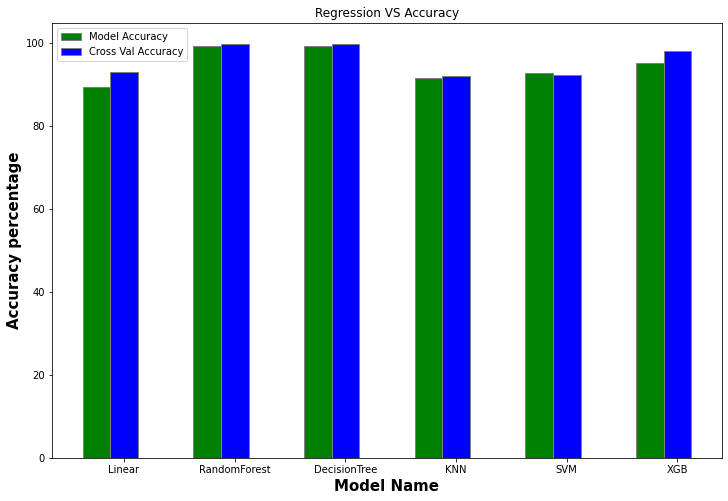

In [ ]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(model_list))
br2 = [x + barWidth for x in br1]
 
plt.bar(br1, accuracy_list, color ='g', width = barWidth,
        edgecolor ='grey', label ='Model Accuracy')
plt.bar(br2, cv_accuracy_list, color ='b', width = barWidth,
        edgecolor ='grey', label ='Cross Val Accuracy')

plt.xlabel('Model Name', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy percentage', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(model_list))],model_list)
plt.title("Regression VS Accuracy")
 
plt.legend()
plt.show()

Here we are comparing the train and test error of the model we check if the model is overfitting or underfitting.

As we can see from the table as the train error is under 10% and also the test error is nearer to the train error i.e, their difference is minimum we can say that the model is not overfitted and also we can say that the model is not underfiited seeing the table.

In [ ]:
col={'Train Error':train_error,'Test Error':test_error}
models = model_list
df3=pd.DataFrame(data=col,index=models)
df3

,Train Error,Test Error
Linear,10.95,10.75
RandomForest,0.34,0.76
DecisionTree,0.00,0.76
KNN,8.09,8.58
SVM,6.98,7.19
XGB,4.90,4.82


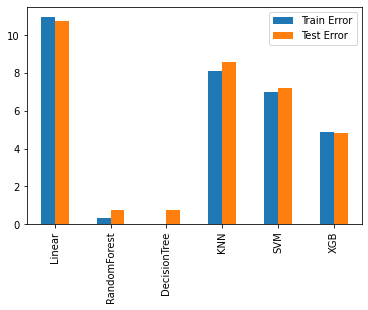

In [ ]:
df3.plot(kind='bar')